In [1]:

import numpy as np 
import pandas as pd 

from fastai import *
from fastai.vision import *

import os
print(os.listdir("../input"))



['train', 'test', 'depths.csv', 'train.csv', 'sample_submission.csv']


In [2]:
path=Path('../input/train')

In [3]:
path_imgs= path/'images'
path_lbls= path/'masks'

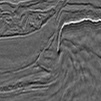

In [4]:
img_f= path_imgs.ls()[0]
img=open_image(img_f)
img

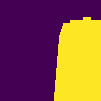

In [5]:
get_labels= lambda x: path_lbls/f'{x.stem}{x.suffix}'
mask=open_mask(get_labels(img_f))
mask

In [6]:
class SaltSegmentationLabelList(SegmentationLabelList):
    def open(self,fn): return open_mask(fn, div=True)
    
class SaltSegmentationItemList(ImageList):
    _label_cls= SaltSegmentationLabelList


In [7]:
src=(SaltSegmentationItemList.from_folder(path/'images')
     .split_by_rand_pct()
     .label_from_func(get_labels, classes=['void','salt']))

In [8]:
data = (src.transform(get_transforms(), size=(224,224), tfm_y=True)
        .databunch(bs=16)
        .normalize(imagenet_stats))

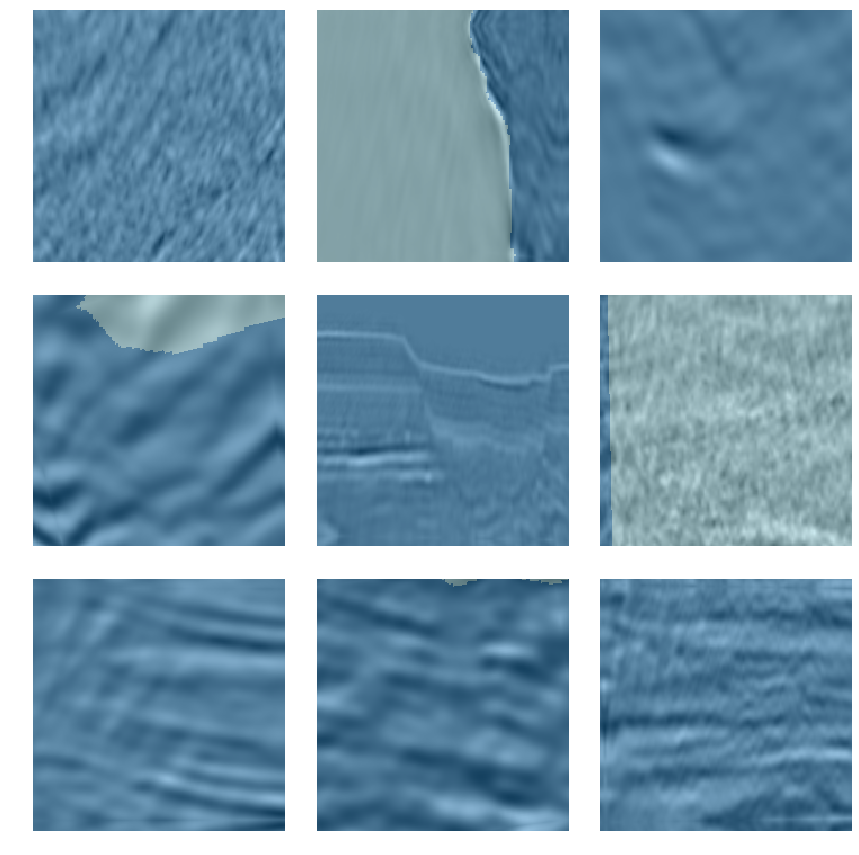

In [14]:
data.show_batch(rows=3, alpha=0.5)

In [16]:
def dice(input:Tensor, targs:Tensor, iou:bool=False)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return 2. * intersect / union
    else: return intersect / (union-intersect+1.0)

def accuracy_salt(input, target):
    target=target.squeeze(1)
    mask =target>0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [11]:
learner= unet_learner(data, models.resnet34, metrics=[accuracy_salt,dice], model_dir="/tmp/models/") 

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 77476949.10it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


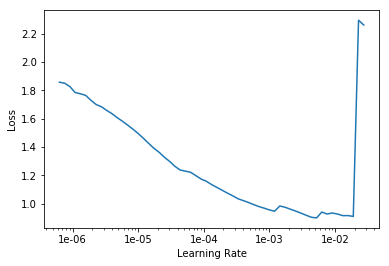

In [12]:
learner.lr_find()
learner.recorder.plot()

In [15]:
lr= 1e-3
learner.fit_one_cycle(5,slice(lr),wd=1e-1)

epoch,train_loss,valid_loss,accuracy_salt,time
0,0.365192,0.384044,0.303700,01:15
1,0.296838,0.221213,0.741398,01:15
2,0.254132,0.206515,0.740485,01:15
3,0.225810,0.193424,0.825132,01:15
4,0.197505,0.176274,0.809279,01:15


In [17]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


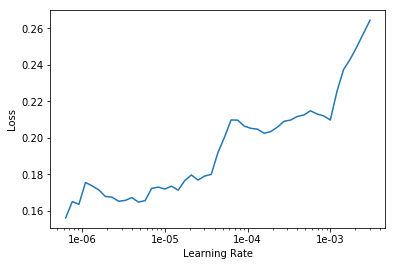

In [18]:
learner.lr_find()
learner.recorder.plot()

In [21]:

learner.fit_one_cycle(10,slice(1e-5,lr/3),wd=1e-1)

epoch,train_loss,valid_loss,accuracy_salt,time
0,0.160293,0.170099,0.833778,01:18
1,0.187920,0.168775,0.803779,01:18
2,0.166769,0.175686,0.863714,01:18
3,0.139059,0.140494,0.874175,01:18
4,0.142852,0.146101,0.891895,01:18


In [22]:
learner.save('salt-1')

In [ ]:
learner.to_fp16()

In [24]:

learner.fit_one_cycle(5,slice(1e-5,lr/3),wd=1e-1)

epoch,train_loss,valid_loss,accuracy_salt,time
0,0.146332,0.146803,0.870828,01:18
1,0.184537,0.184995,0.867174,01:18
2,0.153839,0.175578,0.803796,01:18
3,0.129340,0.143498,0.884594,01:18
4,0.112880,0.138549,0.891709,01:18
